# Colorize point cloud

In [1]:
import numpy as np
import cv2

In [2]:
basedir = '../SemanticKITTI/dataset/sequences/00'

In [3]:
# 1. Load point cloud
file = f'{basedir}/velodyne/000000.bin'
points = np.fromfile(file, dtype=np.float32).reshape(-1, 4) # (x, y, z, intensity)
pts_velo = points[:, :3] # (x, y, z)


# 2. Load image
file = f'{basedir}/image_2/000000.png'
img = cv2.imread(file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

# 3. Load calibration
def load_calib(path):
    calib = {}
    with open(path) as f:
        for line in f:
            key, *vals = line.strip().split()
            calib[key] = np.array(vals, dtype=np.float32).reshape(-1)
    return calib

file = f'{basedir}/calib.txt'
calib = load_calib(file)

P2 = calib['P2:'].reshape(3, 4)  # Left camera projection matrix
Tr = calib['Tr:'].reshape(3, 4) # LiDAR to cam0

In [9]:
from spherical_proj import RangeProjection
projector = RangeProjection(fov_up = 3.0, fov_down = -25.0, proj_w = 2048, proj_h = 64)
# Project the point cloud
proj_pointcloud, proj_range, proj_idx, proj_mask = projector.doProjection(points)


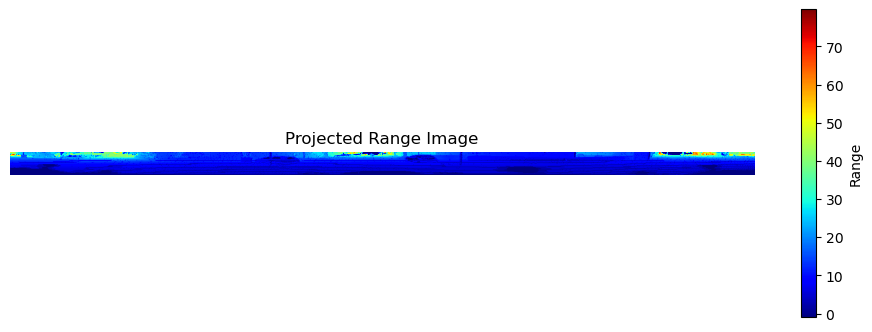

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.imshow(proj_range, cmap='jet')
plt.title('Projected Range Image')
plt.colorbar(label='Range')
plt.axis('off')
plt.show()


In [16]:
# 4. Transform LiDAR points to camera frame
pts_hom = np.hstack((pts_velo, np.ones((pts_velo.shape[0], 1))))  # N×4
pts_cam = ((Tr @ pts_hom.T).reshape(3, -1)).T  # N×3 

# 5. Project to image plane
pts_img = (P2 @ np.hstack((pts_cam, np.ones((pts_cam.shape[0], 1)))).T).T
pts_img[:, 0] /= pts_img[:, 2]
pts_img[:, 1] /= pts_img[:, 2]

# 6. Filter valid points
valid = (pts_cam[:, 2] > 0) & \
        (pts_img[:, 0] >= 0) & (pts_img[:, 0] < w) & \
        (pts_img[:, 1] >= 0) & (pts_img[:, 1] < h)

pts_valid = pts_velo[valid]
uv = pts_img[valid, :2].astype(int)
colors = img[uv[:, 1], uv[:, 0]] / 255.0  # RGB normalized

# print number of valid points along with number of points
print(f'Number of valid points/ Number of points: {np.sum(valid)}/{pts_velo.shape[0]} ({np.sum(valid)/pts_velo.shape[0]*100:.2f}%)')

Number of valid points/ Number of points: 19369/124668 (15.54%)


In [7]:
# cascade the valid array to points
points_add = np.concatenate((points, np.zeros((points.shape[0], 4))), axis=1)
points_add[:, 4] = valid.astype(np.int32)  # Assign 1 if valid, 0 otherwise 
points_add[valid, 5:8] = colors  # RGB

In [8]:
projector2 = RangeProjection(fov_up = 3.0, fov_down = -25.0, proj_w = 2048, proj_h = 64)
# Project the point cloud
proj_pointcloud2, proj_range2, proj_idx2, proj_mask2 = projector2.doProjection(points_add)

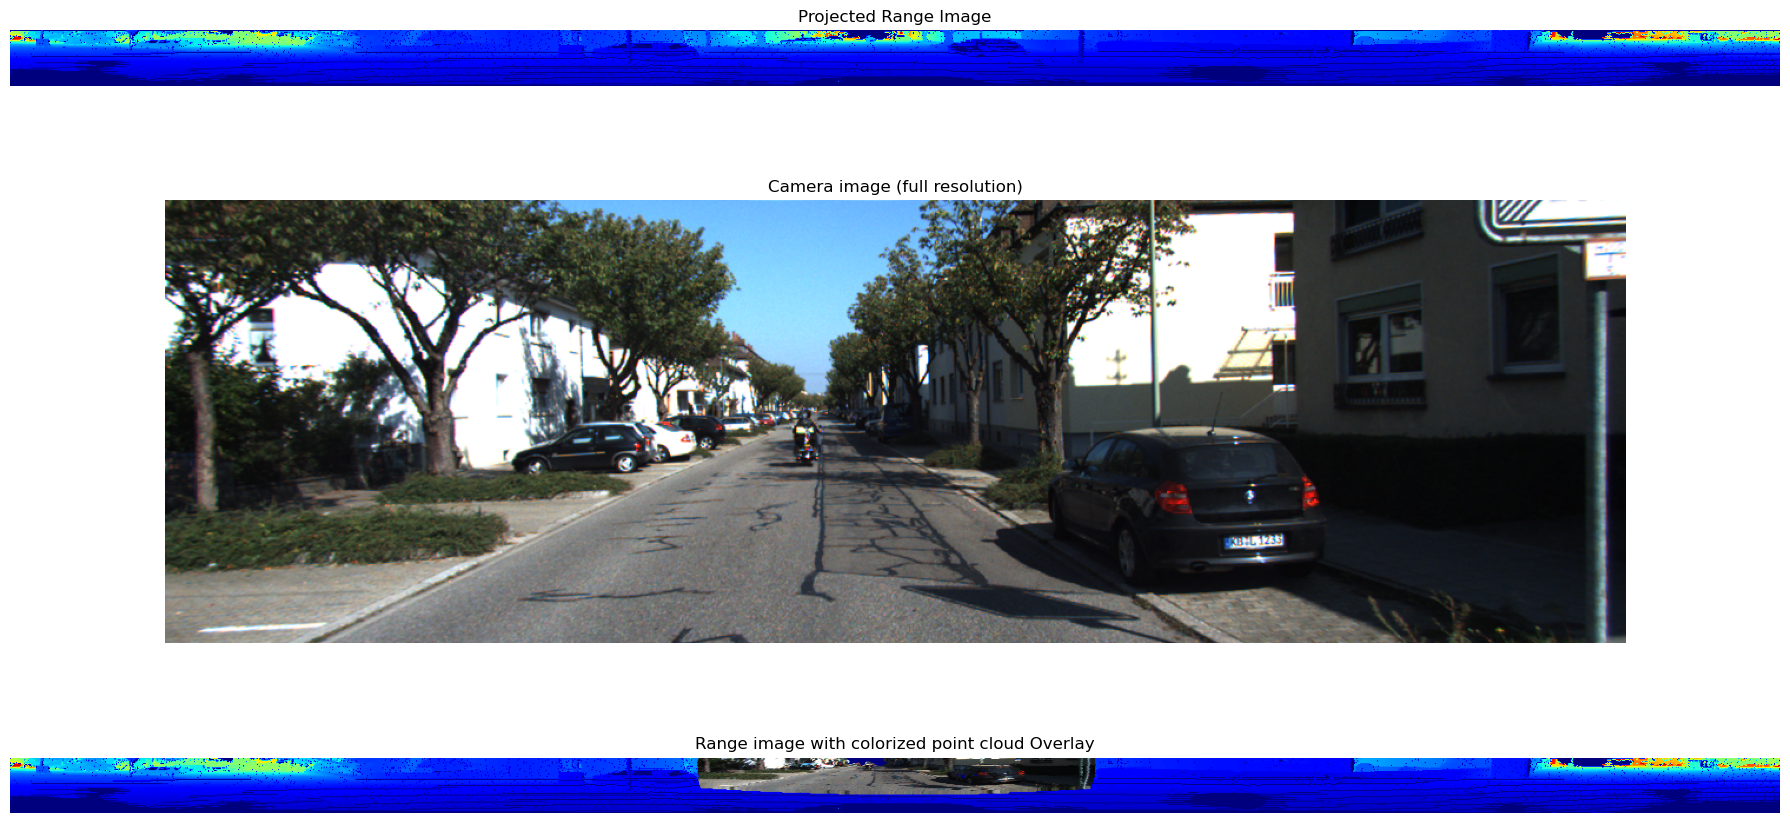

In [ ]:
# plot the projected range image with color. If the valid is 1, set the color to the color of the point, otherwise set it to black


fig, axs = plt.subplots(3, 1, figsize=(18, 12))

# 1. Top: proj_range2 as heatmap (no colorbar)
axs[0].imshow(proj_range2, cmap='jet')
axs[0].set_title('Projected Range Image')
axs[0].axis('off')

# 2. Middle: show the original image
axs[1].imshow(img)
axs[1].set_title('Camera image (full resolution)')
axs[1].axis('off')

# 3. Bottom: heatmap with colored points overlaid
valid_mask = proj_pointcloud2[..., 4] == 1
axs[2].imshow(proj_range2, cmap='jet')
ys, xs = np.where(valid_mask)
colors_d = proj_pointcloud2[ys, xs, 5:8]
axs[2].scatter(xs, ys, c=colors_d, s=2, marker='o')
axs[2].set_title('Range image with colorized point cloud Overlay')
axs[2].axis('off')

plt.tight_layout()
plt.show()


In [17]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts_valid)
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcd])

Dropped Escape call with ulEscapeCode : 0x03007703
